In [1]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/models/")
from swin import BaseSwinUnet
from restormer import BaseRestormer
from bunet import BaseUnet
from noiseadding import build_noise_transforms, CombinedTransforms
from data import get_train_val_dataset, get_dataset, get_train_val_dataset
from metrics import ConfusionMatrix, RMSE
import torchvision
from numba import cuda

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def build_model(model, problem):
    if model == 'restormer':
        if problem == 'deraining':
            model = BaseRestormer(inp_channels=3, out_channels=3, dim=24)
        elif problem == 'denoise':
            model = BaseRestormer(inp_channels=1, out_channels=1, dim=24, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseRestormer(inp_channels=1, out_channels=2, dim=24)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'swin':
        if problem == 'deraining':
            model = BaseSwinUnet(in_chans=3, num_classes=3, embed_dim=48)
        elif problem == 'denoise':
            model = BaseSwinUnet(in_chans=1, num_classes=1, embed_dim=48)
        elif problem == 'firstbreak':
            model = BaseSwinUnet(in_chans=1, num_classes=2, embed_dim=48)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'unet':
        if problem == 'deraining':
            model = BaseUnet(in_channels=3, out_channels=3)
        elif problem == 'denoise':
            model = BaseUnet(in_channels=1, out_channels=1)
        elif problem == 'firstbreak':
            model = BaseUnet(in_channels=1, out_channels=2)
        else:
            raise ValueError('Undefined problem!')
    else:
        raise ValueError('Undefined model!')
    return model

In [4]:
model_type='swin'
problem='denoise'
if problem == 'firstbreak':
    metrics = ConfusionMatrix(2, ["empty", "firstbreak"])
else:
    metrics = RMSE()
noise_type = -1
noise_scale = 0.0
batch_size=8
workers=4
METADATA = '../metadata/'

In [5]:
model = build_model(model_type, problem)
device = torch.device("cpu")
model.to(device)
weight_file = '../metadata/swin_denoise_noisetype_3_noisescale_0.25_dataclip_True_attack_none_pretrained_False'
save_path = os.path.join(METADATA, weight_file + '.pkl')
model.load_state_dict(torch.load(save_path))
model.eval()
# model.unet.encoder1[0].weight

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


BaseSwinUnet(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 48, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=48, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=48, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=48, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=48, out_features=144, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=48, out_features=48, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm(

In [6]:
def evaluate(model, loader, metrics):
    metrics.reset()
    for i, (sample) in enumerate(loader):
        x, y = sample['input'].float(), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            if problem == 'firstbreak':
                y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    return metrics.get()

def evaluate_robustness(model, metrics):
    robustness = np.zeros([4,4])
    for i, noise_type in enumerate(range(4)):
        for j, noise_scale in enumerate([0.25,0.5,1.0,2.0]):
            noise_transforms = build_noise_transforms(noise_type=noise_type, scale=noise_scale)
            denoise_dataset = get_dataset(problem, noise_transforms=noise_transforms)
            _, val_dataset = get_train_val_dataset(denoise_dataset)
            valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
            robustness[i, j] = evaluate(model, valid_loader, metrics)
            print(noise_type, noise_scale, robustness[i, j])
    return robustness

In [18]:
noise_transforms = build_noise_transforms(noise_type=3, scale=0.25)
denoise_dataset = get_dataset(problem, noise_transforms=noise_transforms)
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

evaluate(model, valid_loader, metrics)

___________________________

0.11859118682339367

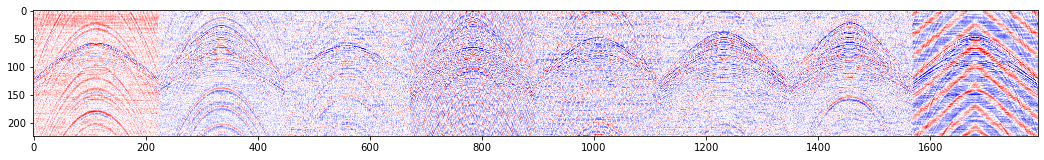

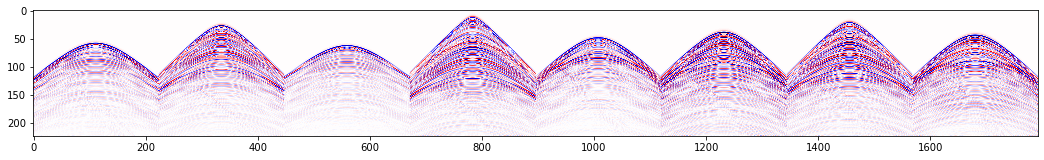

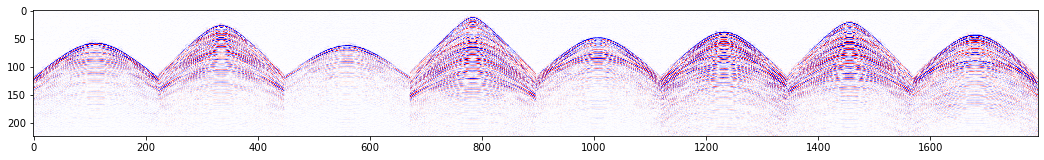

In [19]:
import torchvision
sample = iter(train_loader).next()
x, y = sample['input'].float(), sample['target'].numpy()
with torch.no_grad():
    y_pred = model(x)
    if problem == 'firstbreak':
        y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
plt.figure(figsize=(18,9))
plt.imshow(torchvision.utils.make_grid(sample['input'], padding=0)[0][None, ...].permute((1, 2, 0)), cmap='seismic')
plt.figure(figsize=(18,9))
plt.imshow(torchvision.utils.make_grid(sample['target'].float(), padding=0)[0][None, ...].permute((1, 2, 0)), cmap='seismic')
plt.figure(figsize=(18,9))
plt.imshow(torchvision.utils.make_grid(y_pred.float(), padding=0)[0][None, ...].permute((1, 2, 0)), cmap='seismic')
plt.show()

In [11]:
train_dataset.dataset.rootdir

'/home/makam0a/Dropbox/gendata/data/'

In [10]:
SEISMICDIR

'/home/makam0a/Dropbox/gendata/normalized/'

In [137]:
y_pred.min()

tensor(0.0096)

In [72]:
robustness = evaluate_robustness(model, metrics)
np.save(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'),np.array(robustness))

___________________________0 0.25 2.0980760087033854
___________________________0 0.5 2.1240076975298465
___________________________0 1.0 2.183270423207382
___________________________0 2.0 2.2878985263719733
___________________________1 0.25 2.1097371421298745
___________________________1 0.5 2.1380059503426136
___________________________1 1.0 2.2323250403999406
___________________________1 2.0 2.3111222677431944
___________________________2 0.25 2.110741864399097
___________________________2 0.5 2.151188954999921
___________________________2 1.0 2.270807859128188
___________________________2 2.0 2.3124935233746986
___________________________3 0.25 2.1082168933086733
___________________________3 0.5 2.1615691330548454
___________________________3 1.0 2.280846380027769
__________________

KeyboardInterrupt: 

In [64]:
np.load(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'))

array([[0.35781633, 0.35601395, 0.35224261, 0.35204354],
       [0.35855803, 0.35481191, 0.35676015, 0.35255833],
       [0.3555928 , 0.35291179, 0.35217141, 0.35760074],
       [0.35752324, 0.35486861, 0.35371301, 0.35346244]])

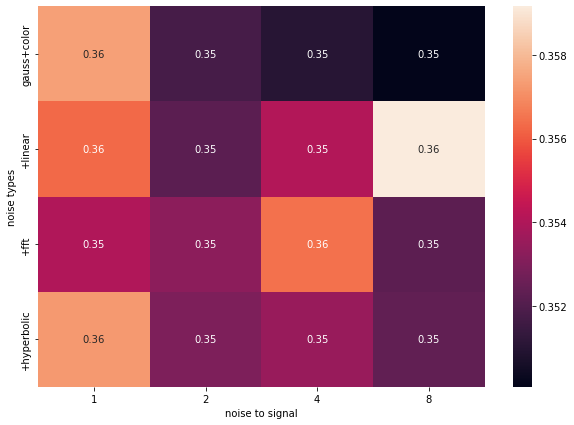

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(robustness, index = [i for i in ['gauss+color', '+linear', '+fft', '+hyperbolic']],
                  columns = [i for i in [1,2,4,8]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('noise to signal')
plt.ylabel('noise types')
plt.show()

In [58]:
for noise_type in [0,1,2,3]:
    for noise_scale in [0.25,0.5]:
        model = build_model(model_type, problem)
        device = torch.device("cpu")
        model.to(device)
        try:
            weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}_attack_fgsm_pretrained_False'
            save_path = os.path.join(METADATA, weight_file + '.pkl')
            model.load_state_dict(torch.load(save_path))
            model.eval()
        except:
            weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}_attack_fgsm'
            save_path = os.path.join(METADATA, weight_file + '.pkl')
            model.load_state_dict(torch.load(save_path))
            model.eval()
        print(weight_file)
        robustness = evaluate_robustness(model, metrics)
        np.save(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'),np.array(robustness))

unet_firstbreak_noisetype_0_noisescale_0.25_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.999214130963155
___________________________0 0.5 0.9988321090708518
___________________________0 1.0 0.9031724369310105
___________________________0 2.0 0.7154659970190496
___________________________1 0.25 0.9991573535759334
___________________________1 0.5 0.9951676644482208
___________________________1 1.0 0.7693230892424239
___________________________1 2.0 0.7081416650596806
___________________________2 0.25 0.9991593941449862
___________________________2 0.5 0.9867285077084503
___________________________2 1.0 0.74576487357778
___________________________2 2.0 0.7073732504020318
___________________________3 0.25 0.9985162763986817
___________________________3 0.5 0.9634315940548455
___________________________3 1.0 0.7369324065811215
___________________________3 2.0 0.7062731413587284
unet_firstbreak_noisetype_0_noisescale_0.5_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9988832014373337
___________________________0 0.5 0.9988817286909921
___________________________0 1.0 0.9948960311203685
___________________________0 2.0 0.8691778683672122
___________________________1 0.25 0.9989550693198617
___________________________1 0.5 0.9988296289283033
___________________________1 1.0 0.9793789370826149
___________________________1 2.0 0.8232102769462313
___________________________2 0.25 0.9989230063632244
___________________________2 0.5 0.9987662114476225
___________________________2 1.0 0.9487732911945745
___________________________2 2.0 0.816088714462323
___________________________3 0.25 0.9989317458572076
___________________________3 0.5 0.9986654918087492
___________________________3 1.0 0.9233032888429782
___________________________3 2.0 0.8089140348400379
unet_firstbreak_noisetype_1_noisescale_0.25_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9990799170503342
___________________________0 0.5 0.9987750945001408
___________________________0 1.0 0.98383040409908
___________________________0 2.0 0.8617439580009604
___________________________1 0.25 0.9991028509263966
___________________________1 0.5 0.997880079584853
___________________________1 1.0 0.95608322995995
___________________________1 2.0 0.8324198492697077
___________________________2 0.25 0.9990205345009597
___________________________2 0.5 0.9979039209732581
___________________________2 1.0 0.9291823417377909
___________________________2 2.0 0.8144118230195048
___________________________3 0.25 0.999118803561565
___________________________3 0.5 0.9957903021557857
___________________________3 1.0 0.9041828077293836
___________________________3 2.0 0.8145884419517693
unet_firstbreak_noisetype_1_noisescale_0.5_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9989643010608935
___________________________0 0.5 0.9989255670130646
___________________________0 1.0 0.9972648832741877
___________________________0 2.0 0.877968580146026
___________________________1 0.25 0.9989837323536693
___________________________1 0.5 0.9990095716172325
___________________________1 1.0 0.9822561855570001
___________________________1 2.0 0.8201205134235264
___________________________2 0.25 0.9989331102427975
___________________________2 0.5 0.9989539134364583
___________________________2 1.0 0.9517086501354715
___________________________2 2.0 0.8167798969031783
___________________________3 0.25 0.9990250417785169
___________________________3 0.5 0.9988298843342985
___________________________3 1.0 0.9204954820152438
___________________________3 2.0 0.814704328124056
unet_firstbreak_noisetype_2_noisescale_0.25_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9990531669089002
___________________________0 0.5 0.9987231677169741
___________________________0 1.0 0.9085596018576766
___________________________0 2.0 0.7755487258852466
___________________________1 0.25 0.9990970124749202
___________________________1 0.5 0.9917723761774502
___________________________1 1.0 0.8181289163029577
___________________________1 2.0 0.7687120963581691
___________________________2 0.25 0.9991094009251512
___________________________2 0.5 0.9781595608188128
___________________________2 1.0 0.7992108165713449
___________________________2 2.0 0.7723902524683981
___________________________3 0.25 0.9990842435295741
___________________________3 0.5 0.9638159420728116
___________________________3 1.0 0.7856317723044222
___________________________3 2.0 0.7699231558450137
unet_firstbreak_noisetype_2_noisescale_0.5_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9987486839611408
___________________________0 0.5 0.9988198872509599
___________________________0 1.0 0.9981955032911467
___________________________0 2.0 0.8905051872352552
___________________________1 0.25 0.998673728274709
___________________________1 0.5 0.9988430817924887
___________________________1 1.0 0.9876867670583234
___________________________1 2.0 0.8426778225793458
___________________________2 0.25 0.9988328398838957
___________________________2 0.5 0.9987435768224419
___________________________2 1.0 0.9683132665682994
___________________________2 2.0 0.8406383458543982
___________________________3 0.25 0.9987148492541795
___________________________3 0.5 0.9986217812269844
___________________________3 1.0 0.9361840702484939
___________________________3 2.0 0.8399352323337104
unet_firstbreak_noisetype_3_noisescale_0.25_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9991669278389179
___________________________0 0.5 0.9987678338808044
___________________________0 1.0 0.9584520586273839
___________________________0 2.0 0.7718998441910068
___________________________1 0.25 0.9991071574951033
___________________________1 0.5 0.9981565036771838
___________________________1 1.0 0.8880635293918544
___________________________1 2.0 0.740954500715542
___________________________2 0.25 0.9991598101603733
___________________________2 0.5 0.9961342984158775
___________________________2 1.0 0.8176653118916234
___________________________2 2.0 0.7335911680273091
___________________________3 0.25 0.999096196887758
___________________________3 0.5 0.9922165376375844
___________________________3 1.0 0.789054739522921
___________________________3 2.0 0.7316279669065057
unet_firstbreak_noisetype_3_noisescale_0.5_attack_fgsm


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


___________________________0 0.25 0.9989548805939201
___________________________0 0.5 0.9989040087023866
___________________________0 1.0 0.9973050335016245
___________________________0 2.0 0.8788190875256703
___________________________1 0.25 0.9989903460971495
___________________________1 0.5 0.9988957943491976
___________________________1 1.0 0.9931456575568489
___________________________1 2.0 0.8321371587566517
___________________________2 0.25 0.9984994625613841
___________________________2 0.5 0.9984976714302387
___________________________2 1.0 0.9761129715561248
___________________________2 2.0 0.8213713404699009
___________________________3 0.25 0.9990448633102269
___________________________3 0.5 0.9989126596213507
___________________________3 1.0 0.9514805661478161
___________________________3 2.0 0.8081783409411907


In [30]:
noise_type = 3
noise_scale = 2.0
weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}'
robustness = np.load(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'))

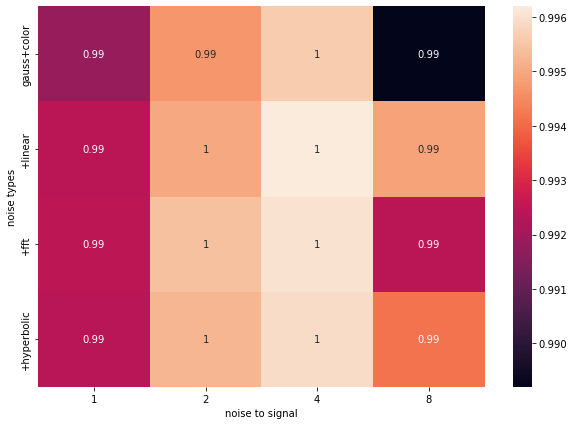

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(robustness, index = [i for i in ['gauss+color', '+linear', '+fft', '+hyperbolic']],
                  columns = [i for i in [1,2,4,8]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('noise to signal')
plt.ylabel('noise types')
plt.show()